In [125]:
#!pip install geopy
#!pip install folium

#I want to make sure I get all the libraries in here that I will need.
import numpy as np 
import pandas as pd 
import requests 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import types
from sklearn.cluster import KMeans
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
!pip install folium --upgrade
import folium

print('All Systems Go...')

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.9.2




All Systems Go...



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: C:\Users\jgles\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [126]:
vbhoods = pd.read_csv(r'C:\Users\jgles\OneDrive\Documents\Code Folderz\dawg\dawg\ML\HRDF.csv')
#vbhoods.head()


In [127]:
address = '310 Edwin Dr, Virginia Beach, VA 23462'

geolocator = Nominatim(user_agent="vb_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Virginia Beach, VA are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Virginia Beach, VA are 36.82561863221752, -76.13125795922382.


In [128]:
# create map of Va Beach using latitude and longitude values
map_vb = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(vbhoods['Lat'], vbhoods['Long'], vbhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='#78609e',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vb)  
    
map_vb

In [129]:
CLIENT_ID = 'TVJWUE15PRCVHC0JWOGO0DQMGUJT11D0REZ04AJK1G2JZ3HY' # your Foursquare ID
CLIENT_SECRET = 'DQ2E1HBT4GPJVRIAURN04Q5VVAAVVDWSJNHYDPP4TJG5OKGI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TVJWUE15PRCVHC0JWOGO0DQMGUJT11D0REZ04AJK1G2JZ3HY
CLIENT_SECRET:DQ2E1HBT4GPJVRIAURN04Q5VVAAVVDWSJNHYDPP4TJG5OKGI


In [130]:
#vbhoods.loc[1, 'Neighborhood']

In [131]:
neighborhood_latitude = vbhoods.loc[2, 'Lat'] # neighborhood latitude value
neighborhood_longitude = vbhoods.loc[2, 'Long'] # neighborhood longitude value

neighborhood_name = vbhoods.loc[2, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Pembroke are 36.8650521869, -76.1240022262.


In [132]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
#url  

In [133]:
#Here is where we will go ahead and make the pulls of data.  Lets make sure we are good here

In [134]:
results = requests.get(url).json()
#results

In [135]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [136]:
from pandas.io.json import json_normalize
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

#nearby_venues.head()

C:\Users\jgles\AppData\Local\Temp\ipykernel_12240\2633694355.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  nearby_venues = json_normalize(venues) # flatten JSON


In [137]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

15 venues were returned by Foursquare.


In [138]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [139]:
vb_venues = getNearbyVenues(names=vbhoods['Neighborhood'],
                                   latitudes=vbhoods['Lat'],
                                   longitudes=vbhoods['Long']
                                  )


Cape Story by the Sea
Alanton
Pembroke
Kings Grant
Macons Corner
Lynnhaven Shores
Acredale
Bay Colony
Sandbridge
First Landing State Park
Linkhorn Park
US Navy Little Creek Amphibious Base
Broad Bay Colony
Rudee Heights
Kempsville
Bayside
Seatack
Croatan Beach
Mears Corner
Princess Anne Plaza
Thalia
Oceana
The North End
Princess Anne
Dams Neck Naval Air Station
Thoroughgood
Naval Air Station Oceana
Chesapeake Beach
Chesapeake Beach
Great Neck
Green Run
Salem
Indian River
Great Bridge
Western Branch North
Butts Station
South Norfolk
South Norfolk
Deep Creek North
Great Bridge East
Western Branch South
Pleasant Grove West
Greenbrier West
Deep Creek South
Greenbrier East
Deep Creek West-Dismal Swamp
Pleasant Grove East
The Gardens
Edgewater
Camellia Gardens
Estabrook
Lochhaven
Bowling Green
West Ghent
Wards Corner
Wellington Oaks
Norview
Talbot Park
Glengariff
Lamberts Point
Greenhill Farms
Waverly on Broad Creek
Bolling Brook
River Point
Bel-Aire
Sherwood Forest
Highland Park
Poplar Hall

In [140]:
vb_venues.shape

(3040, 7)

In [141]:
venue_hist=vb_venues.groupby('Neighborhood').count()
venue_hist.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1, inplace=True)
venue_hist.head()

,Venue
Neighborhood,
Acredale,3
Alanton,2
Algonquin,5
Ballentine Place,14
Bay Colony,2


Text(0.5, 0, '# of Venues')

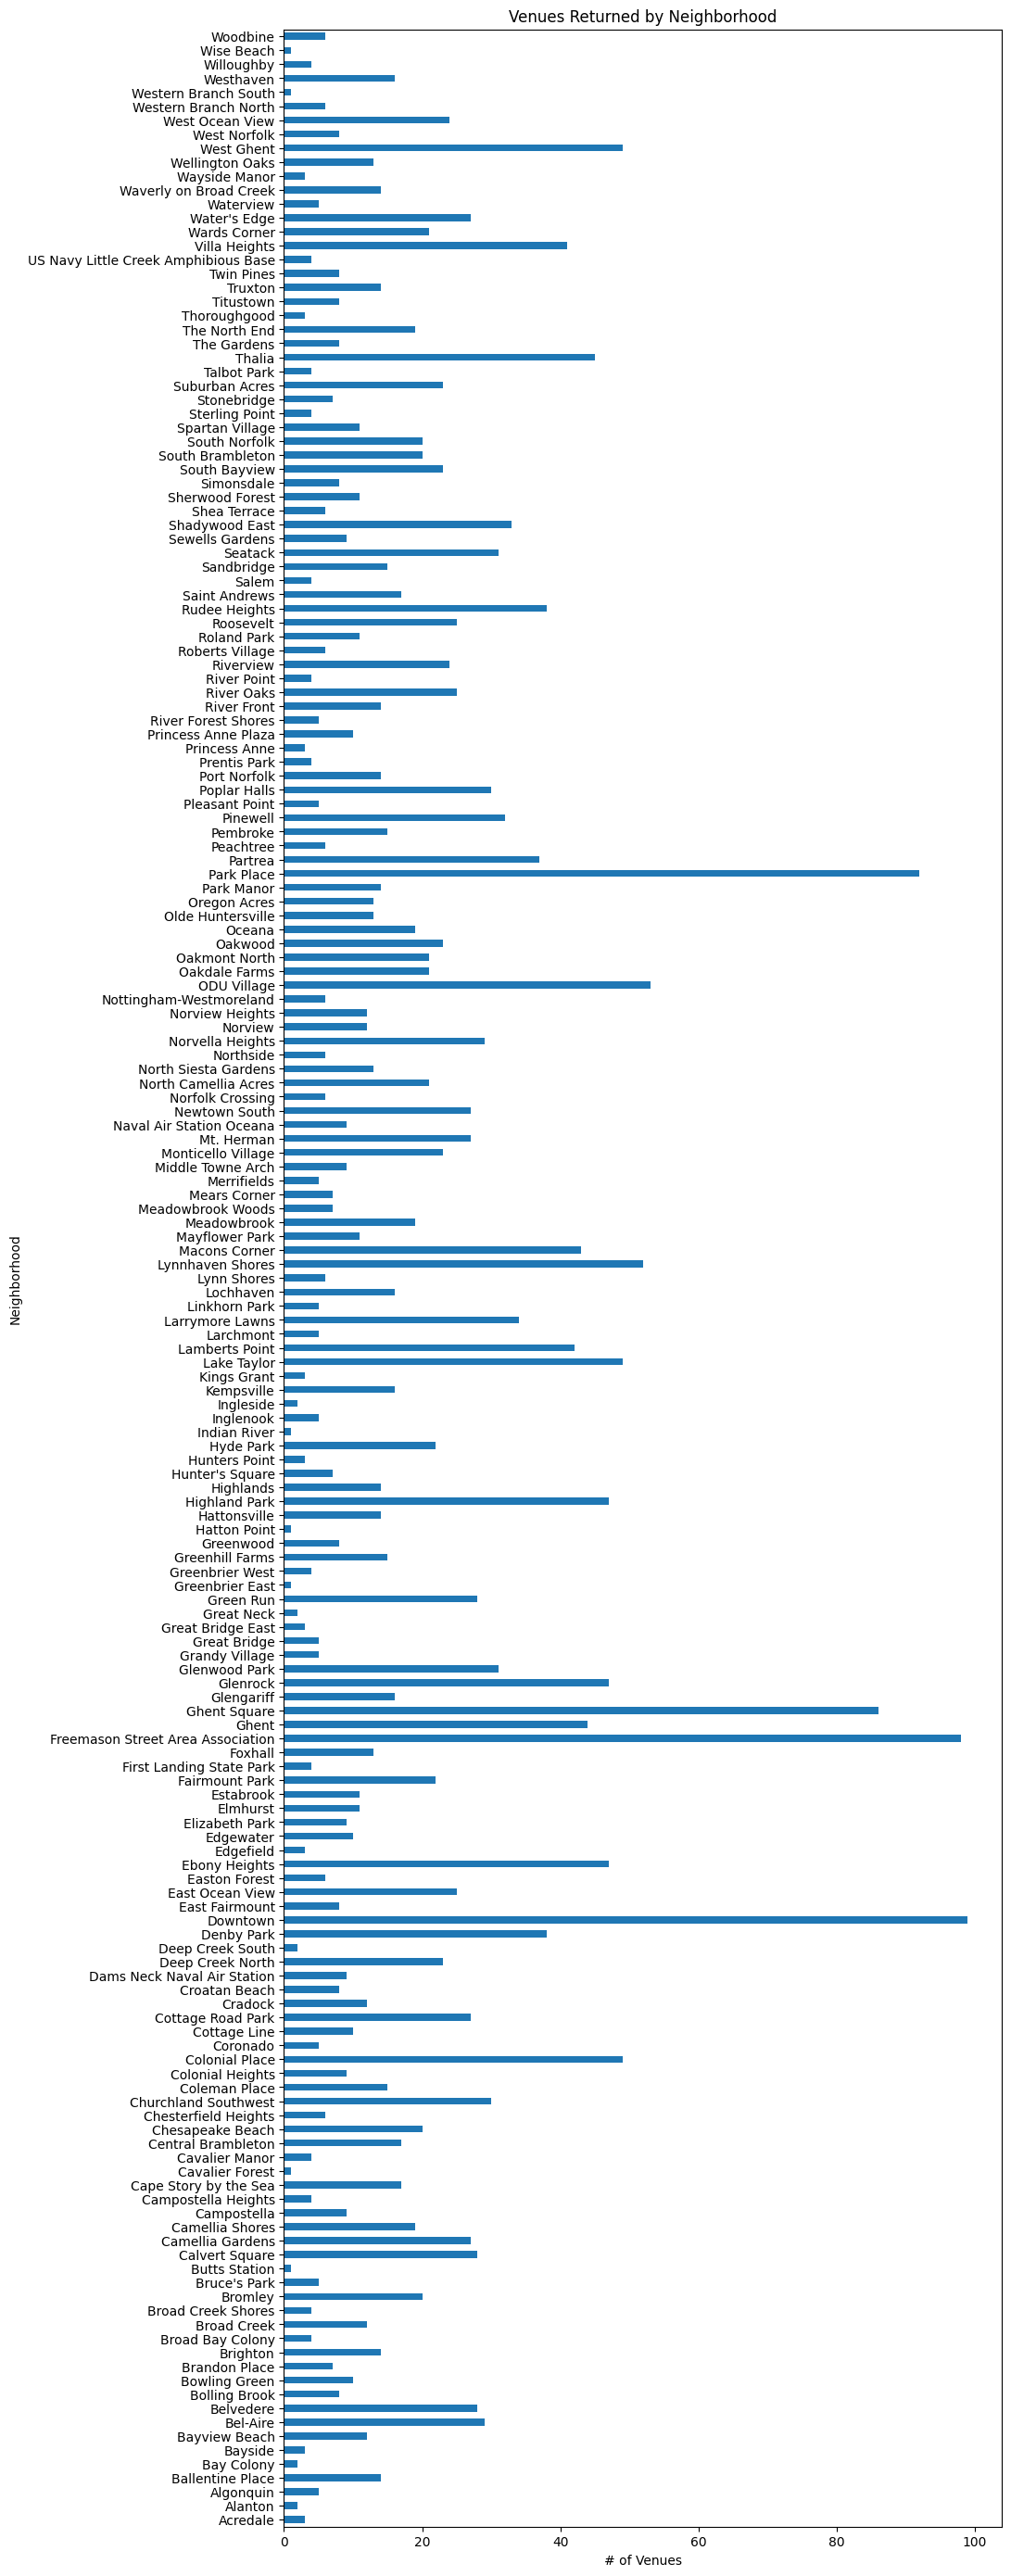

In [142]:
venue_hist['Venue'].plot(kind='barh', figsize=(10,35))

plt.title('Venues Returned by Neighborhood') # add a title to the histogram
plt.ylabel('Neighborhood') # add y-label
plt.xlabel('# of Venues') # add x-label
#plt.savefig('venues-neighborhoods.png')

In [143]:
print('There are {} uniques categories.'.format(len(vb_venues['Venue Category'].unique())))

There are 254 uniques categories.


In [144]:
# one hot encoding
vb_onehot = pd.get_dummies(vb_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vb_onehot['Neighborhood'] = vb_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [vb_onehot.columns[-1]] + list(vb_onehot.columns[:-1])
vb_onehot = vb_onehot[fixed_columns]

vb_onehot.head()

,Zoo,Adult Store,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Store,Aquarium,...,Vietnamese Restaurant,Vintage and Thrift Store,Warehouse or Wholesale Store,Waterfront,Whisky Bar,Wine Bar,Wine Store,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [145]:
vb_onehot.shape

(3040, 254)

In [146]:
vb_grouped = vb_onehot.groupby('Neighborhood').mean().reset_index()
vb_grouped

,Neighborhood,Zoo,Adult Store,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Store,...,Vietnamese Restaurant,Vintage and Thrift Store,Warehouse or Wholesale Store,Waterfront,Whisky Bar,Wine Bar,Wine Store,Wings Joint,Women's Store,Yoga Studio
0,Acredale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alanton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Algonquin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ballentine Place,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bay Colony,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,Western Branch South,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175,Westhaven,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176,Willoughby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,Wise Beach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
num_top_venues = 5

for hood in vb_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = vb_grouped[vb_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Acredale----
           venue  freq
0           Park  0.67
1  Shopping Mall  0.33
2   Outlet Store  0.00
3  Moving Target  0.00
4         Museum  0.00


----Alanton----
           venue  freq
0  Boat or Ferry   0.5
1     Sports Bar   0.5
2            Zoo   0.0
3          Mover   0.0
4  Moving Target   0.0


----Algonquin----
                venue  freq
0  Chinese Restaurant   0.4
1                Park   0.2
2       Garden Center   0.2
3            Pizzeria   0.2
4         Music Venue   0.0


----Ballentine Place----
                 venue  freq
0                Diner  0.14
1    Convenience Store  0.14
2  Fried Chicken Joint  0.07
3             Pharmacy  0.07
4         Fuel Station  0.07


----Bay Colony----
           venue  freq
0      Bookstore   0.5
1       Bus Stop   0.5
2  Movie Theater   0.0
3  Moving Target   0.0
4         Museum   0.0


----Bayside----
                   venue  freq
0  Sporting Goods Retail  0.33
1            Art Gallery  0.33
2               Dog Park  0.33

In [148]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [149]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = vb_grouped['Neighborhood']

for ind in np.arange(vb_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vb_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Acredale,Park,Shopping Mall,Outlet Store,Moving Target,Museum
1,Alanton,Boat or Ferry,Sports Bar,Zoo,Mover,Moving Target
2,Algonquin,Chinese Restaurant,Park,Garden Center,Pizzeria,Music Venue
3,Ballentine Place,Diner,Convenience Store,Fried Chicken Joint,Pharmacy,Fuel Station
4,Bay Colony,Bookstore,Bus Stop,Movie Theater,Moving Target,Museum


In [150]:
# set number of clusters
kclusters = 4

vb_grouped_clustering = vb_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

C:\Users\jgles\AppData\Local\Temp\ipykernel_12240\3750738735.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  vb_grouped_clustering = vb_grouped.drop('Neighborhood', 1)


array([1, 3, 3, 3, 0, 3, 3, 3, 0, 0, 2, 2, 3, 3, 2, 2, 0, 2, 3, 3, 3, 0,
       2, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 0, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3,
       2, 3, 3, 3, 3, 0, 1, 0, 2, 3, 3, 3, 3, 0, 0, 0, 3, 3, 0, 3, 1, 1,
       3, 3, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 3, 0, 3, 3, 0, 0, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 0, 3, 2, 0, 3, 3, 3, 2, 3, 0, 3, 2, 2, 2, 3,
       0, 0, 3, 0, 0, 3, 3, 2, 0, 0, 2, 3, 3, 1, 3, 3, 2, 3, 3, 1, 3, 3,
       1, 0, 2, 2, 3, 3, 0, 3, 3, 0, 2, 2, 3, 3, 3, 3, 2, 2, 2, 1, 2, 0,
       1, 0, 3, 3, 1, 2, 3, 3, 3, 3, 0, 3, 2, 3, 3, 2, 0, 2, 3, 3, 3, 2,
       3, 1, 1])

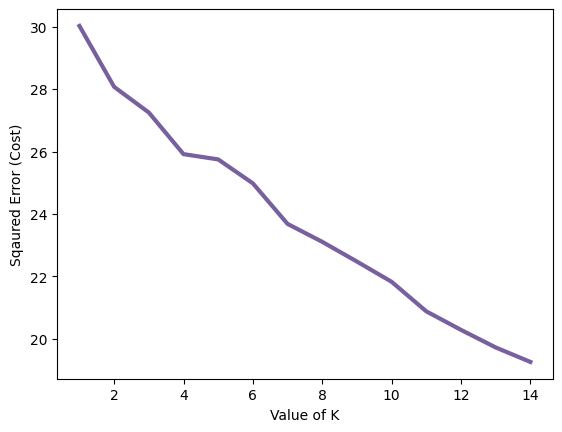

In [151]:
# Setting up Elbow Analysis
cost =[] 
for i in range(1, 15): 
	KM = KMeans(n_clusters = i, max_iter = 500) 
	KM.fit(vb_grouped_clustering) 
	
	# calculates squared error 
	# for the clustered points 
	cost.append(KM.inertia_)	 

# plot the cost against K values 
plt.plot(range(1, 15), cost, color ='#78609e', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

# the point of the elbow is the 
# most optimal value for choosing k 

In [152]:
#Hide this code when running a new pass
#vb_merged.drop(['Cluster Labels'], axis=1, inplace=True)
#vb_merged.head()

In [153]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

vb_merged = vbhoods

# merge to add latitude/longitude for each neighborhood
vb_merged = vb_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

#vb_merged.head(50) # check the last rows!
vb_merged.sort_values(by="Cluster Labels")

,Lat,Long,City,Neighborhood,Zillow Home Value,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized,...,Zillow Rent Index,Monthly +/- Rent,Quarterly +/- Rent,Yearly +/- Rent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
66,36.886632,-76.295454,Norfolk City,Highland Park,171900,0.001,0.007,0.054,0.02,-0.005,...,NaN,NaN,NaN,NaN,0.0,Sandwich Spot,Pizzeria,Convenience Store,Intersection,Chinese Restaurant
147,36.920606,-76.262741,Norfolk City,Monticello Village,192200,0.008,0.021,0.079,0.051,0.015,...,NaN,NaN,NaN,NaN,0.0,Supermarket,Discount Store,Fast Food Restaurant,Mexican Restaurant,Coffee Shop
42,36.743499,-76.254699,Chesapeake City,Greenbrier West,245400,0.004,0.010,0.025,0.022,0.003,...,1567,0.002,-0.004,0.01,0.0,Miscellaneous Store,Repair Service,Seafood Restaurant,Mexican Restaurant,Zoo
93,36.846743,-76.234498,Norfolk City,Ingleside,195400,0.004,0.005,0.011,0.037,-0.001,...,NaN,NaN,NaN,NaN,0.0,Cosmetics Store,Sandwich Spot,Outlet Store,Moving Target,Museum
92,36.861437,-76.300460,Norfolk City,Ghent,338200,-0.003,-0.008,0.011,0.009,-0.001,...,NaN,NaN,NaN,NaN,0.0,Chinese Restaurant,Dog Park,American Restaurant,Park,Coffee Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,36.853604,-76.277432,Norfolk City,Calvert Square,180100,0.006,0.019,0.037,0.033,-0.016,...,NaN,NaN,NaN,NaN,3.0,Theater,Fuel Station,Mediterranean Restaurant,Grocery Store,Frozen Yogurt Shop
188,36.816715,-76.313086,Portsmouth City,Brighton,118000,0.028,0.072,0.220,0.034,0.009,...,---,---,---,---,3.0,Convenience Store,Bowling Alley,Liquor Store,Discount Store,Electronics Store
41,36.617803,-76.296487,Chesapeake City,Pleasant Grove West,427400,0.004,0.010,0.019,0.026,0.009,...,2180,-0.011,-0.027,-0.003,NaN,NaN,NaN,NaN,NaN,NaN
45,36.762027,-76.430618,Chesapeake City,Deep Creek West-Dismal Swamp,317000,0.004,0.009,0.016,0.023,0.007,...,1788,-0.01,-0.023,0.003,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
print(vb_merged['Cluster Labels'].value_counts())

3.0    90
0.0    44
2.0    40
1.0    12
Name: Cluster Labels, dtype: int64


In [155]:
vb_null = vb_merged[vb_merged['Cluster Labels'].isnull()]
vb_null.shape

(3, 24)

In [156]:
#vb_merged.sort_values(by="Cluster Labels")


In [157]:
vb_merged.drop([23,40,41,44,45], inplace=True)
#vb_merged.sort_values(by="Cluster Labels")

In [158]:
vb_merged.to_csv('Clustering_Output.csv')

In [174]:
"""
This script creates a cluster map visualization using Folium, centered on a specified location, and 
assigns each cluster a unique color for easier identification.

Attributes:
    latitude (float): Latitude for centering the map.
    longitude (float): Longitude for centering the map.
    kclusters (int): Number of clusters used in the analysis.
    vb_merged (DataFrame): DataFrame containing the data, including columns for latitude, longitude, 
                           neighborhood names, and cluster labels.
"""

import folium
import numpy as np

# Define high-contrast colors for each cluster
cluster_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFA500']  # Red, Green, Blue, Orange

# Create a map centered at the specified latitude and longitude
map_clusters = folium.Map(
    location=[latitude, longitude],
    tiles='OpenStreetMap',
    attr='Map data © OpenStreetMap contributors',
    zoom_start=11
)

# Add markers for each neighborhood in vb_merged with clearly distinguishable colors
for lat, lon, poi, cluster in zip(vb_merged['Lat'], vb_merged['Long'], vb_merged['Neighborhood'], vb_merged['Cluster Labels']):
    if not np.isnan(cluster):  # Check for NaN in cluster labels
        # Use modulo to ensure we loop through the color list if clusters exceed available colors
        color = cluster_colors[int(cluster) % len(cluster_colors)]
        
        label = folium.Popup(f"{poi} Cluster {int(cluster)}", parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,  # Slightly larger radius for visibility
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6
        ).add_to(map_clusters)

# Display the map
map_clusters




In [160]:
#vb_merged.sort_values(by="Month Over Month", ascending=False)

In [161]:
#We will create dfs for each cluster so that we can study them in detail.
clus0=vb_merged.loc[vb_merged['Cluster Labels']== 0.0]
#clus0.head()

In [162]:
clus2=vb_merged.loc[vb_merged['Cluster Labels']== 2.0]
#clus2.head()

In [163]:
clus1=vb_merged.loc[vb_merged['Cluster Labels']== 1.0]
#clus1

In [164]:
clus3=vb_merged.loc[vb_merged['Cluster Labels']== 3.0]
#clus3

#clus4=vb_merged.loc[vb_merged['Cluster Labels']== 4.0]
#clus4.head()
#clus5=vb_merged.loc[vb_merged['Cluster Labels']== 5.0]
#clus5.head()
#clus6=vb_merged.loc[vb_merged['Cluster Labels']== 6.0]
#clus6.head()

In [165]:
print("The Rec Areas have a ZHV of ",clus0["Zillow Home Value"].mean(skipna=True))
print("Eastern Euro Areas have a ZHV of ",clus1["Zillow Home Value"].mean(skipna=True))
print("Outlier has a ZHV of ",clus2["Zillow Home Value"].mean(skipna=True))
print("Strip Mall cluster has a ZHV of ",clus3["Zillow Home Value"].mean(skipna=True))
#print("Beach Neighborhoods have a ZHV of ",clus4["Zillow Home Value"].mean(skipna=True))
#print("Residential Areas has a ZHV of ",clus5["Zillow Home Value"].mean(skipna=True))

The Rec Areas have a ZHV of  249063.63636363635
Eastern Euro Areas have a ZHV of  333650.0
Outlier has a ZHV of  176210.0
Strip Mall cluster has a ZHV of  282429.8850574713


In [175]:
print("The Rec Areas have a Yearly Growth Rate of ",clus0["Year Over Year"].mean(skipna=True))
print("Eastern Euro Areas have a Yearly Growth Rate of ",clus1["Year Over Year"].mean(skipna=True))
print("Outlier has a Yearly Growth Rate of ",clus2["Year Over Year"].mean(skipna=True))
print("Strip Mall cluster has a Yearly Growth Rate of ",clus3["Year Over Year"].mean(skipna=True))
#print("Beach Neighborhoods have Yearly Growth Rate of ",clus4["Year Over Year"].mean(skipna=True))
#print("Residential Areas has a Yearly Growth Rate of ",clus5["Year Over Year"].mean(skipna=True))

The Rec Areas have a Yearly Growth Rate of  0.03663636363636364
Eastern Euro Areas have a Yearly Growth Rate of  0.028249999999999997
Outlier has a Yearly Growth Rate of  0.042125
Strip Mall cluster has a Yearly Growth Rate of  0.04117241379310345


In [177]:
data = {'Cluster Label': [0,1,3,4,5], 'Cluster Alias': ['Recreational Area', 'Eastern European Area', 'Strip Mall Area', 'Beach Areas', 'Residential Areas'], 'Mean Zillow Home Value':[444083,301675,219742,476675,246850]}
mean_ZHV=pd.DataFrame.from_dict(data)
mean_ZHV.head()

,Cluster Label,Cluster Alias,Mean Zillow Home Value
0,0,Recreational Area,444083
1,1,Eastern European Area,301675
2,3,Strip Mall Area,219742
3,4,Beach Areas,476675
4,5,Residential Areas,246850


In [168]:
#mean_ZHV.drop(['Cluster Label'], axis=1, inplace=True)
mean_ZHV=mean_ZHV.set_index('Cluster Label')
mean_ZHV.head()

,Cluster Alias,Mean Zillow Home Value
Cluster Label,,
0,Recreational Area,444083
1,Eastern European Area,301675
3,Strip Mall Area,219742
4,Beach Areas,476675
5,Residential Areas,246850


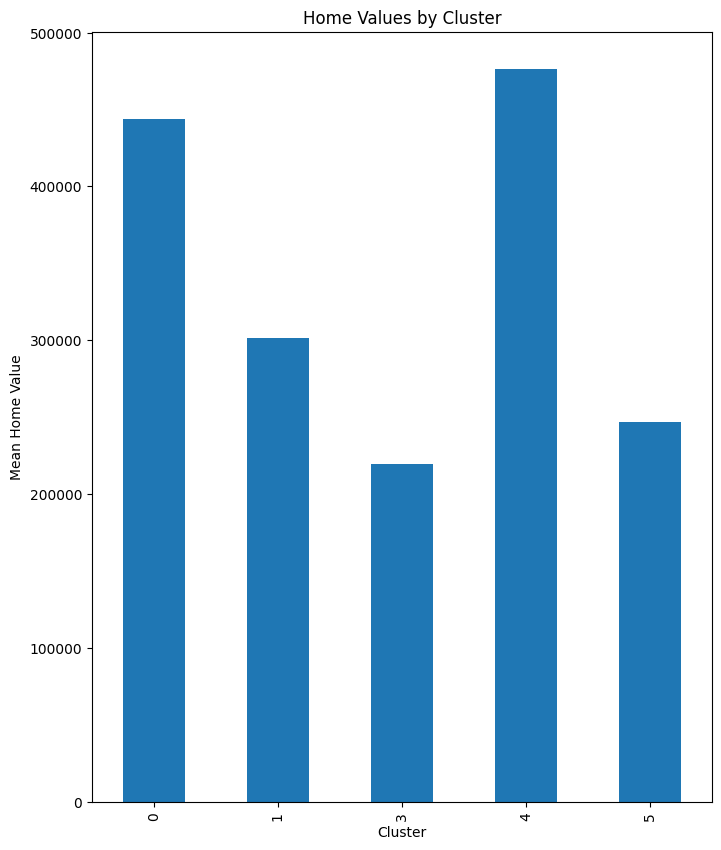

In [169]:
mean_ZHV['Mean Zillow Home Value'].plot(kind='bar', figsize=(8,10))

plt.title('Home Values by Cluster') # add a title to the histogram
plt.ylabel('Mean Home Value') # add y-label
plt.xlabel('Cluster') # add x-label
plt.savefig('Home Values By Cluster.png')

In [170]:
#Lets do the chart on the home value growth now.

data = {'Cluster Label': [0,1,3,4,5], 'Cluster Alias': ['Recreational Area', 'Eastern European Area', 'Strip Mall Area', 'Beach Areas', 'Residential Areas'], 'Year Over Year Growth (%)':[.0406,.0293,.0434,.0185,.0291]}
mean_growth=pd.DataFrame.from_dict(data)
mean_growth.head()

,Cluster Label,Cluster Alias,Year Over Year Growth (%)
0,0,Recreational Area,0.0406
1,1,Eastern European Area,0.0293
2,3,Strip Mall Area,0.0434
3,4,Beach Areas,0.0185
4,5,Residential Areas,0.0291


In [171]:
mean_growth['Year Over Year Growth (%)']=100*mean_growth['Year Over Year Growth (%)']
mean_growth.head()

,Cluster Label,Cluster Alias,Year Over Year Growth (%)
0,0,Recreational Area,4.06
1,1,Eastern European Area,2.93
2,3,Strip Mall Area,4.34
3,4,Beach Areas,1.85
4,5,Residential Areas,2.91


In [172]:
mean_growth=mean_growth.set_index('Cluster Label')
mean_growth.head()

,Cluster Alias,Year Over Year Growth (%)
Cluster Label,,
0,Recreational Area,4.06
1,Eastern European Area,2.93
3,Strip Mall Area,4.34
4,Beach Areas,1.85
5,Residential Areas,2.91


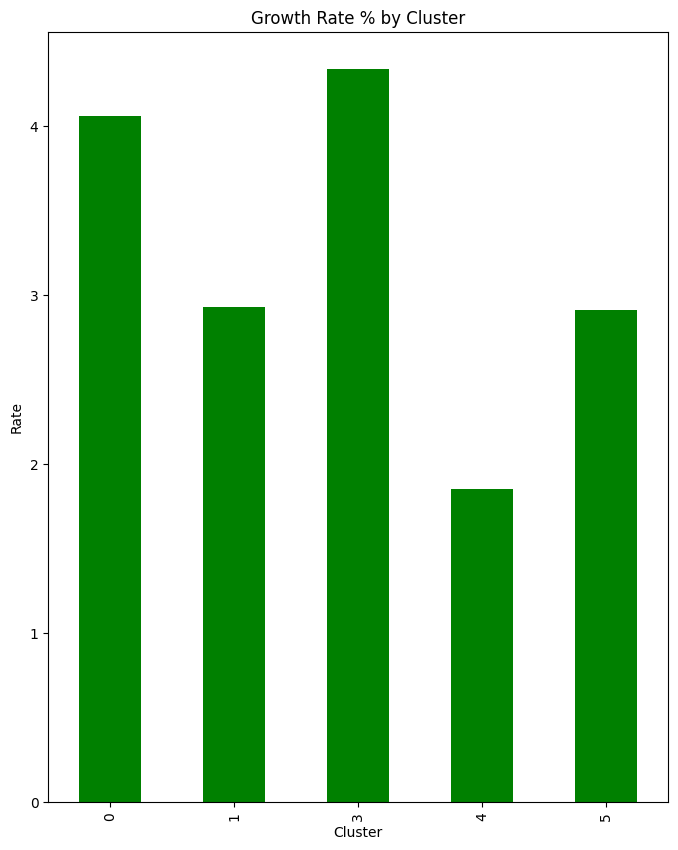

In [173]:
mean_growth['Year Over Year Growth (%)'].plot(kind='bar', color='green', figsize=(8,10))

plt.title('Growth Rate % by Cluster') # add a title to the histogram
plt.ylabel('Rate') # add y-label
plt.xlabel('Cluster') # add x-label
plt.savefig('Growth Rate By Cluster.png')